# Imports
## Dependancies
Ensure matplotlib is downloaded to python envirnment

In [149]:
import random
import math
import matplotlib.pyplot as plt
import time

# VRPTW
## Step by step
1. Run starts a loop the length of the desired iterations
    1. In the loop construct_solution is called and constructs a solution for each iteration
        1. Each ant constructs a routes for all vehicles
        2. select_next_customer is called during route construction to select next customer in route based on attractiveness (how close the customer is to vehicle location, and pheromone trail), and constraint violation (time windows and capacity)
    2. Pheromone trails are updated

In [150]:
class VRPTW:
    def __init__(self, distance_matrix, time_windows, customer_demand, vehicle_capacity=200, max_num_vehicles=25, num_ants=25, num_iterations=100, evaporation_rate=0.95, penalty_factor=10, reward_factor=1, pheromone_multiplier=1, unused_penalty=1, vicinity_factor=1):
        # Initializing params
        self.distance_matrix = distance_matrix
        self.time_windows = time_windows
        self.customer_demand = customer_demand
        self.vehicle_capacity = vehicle_capacity
        self.max_num_vehicles = max_num_vehicles
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.evaporation_rate = evaporation_rate
        self.unused_penalty = unused_penalty
        self.penalty_factor = penalty_factor
        self.reward_factor = reward_factor
        self.pheromone_multiplier = pheromone_multiplier
        self.vicinity_factor = vicinity_factor

        # Initialize pheromone levels for all edges
        self.pheromones = [[1 for _ in range(len(distance_matrix))] for _ in range(len(distance_matrix))]
        
        # Initializing global variables
        self.best_solution = None
        self.best_cost = float('inf') # Set to infinite so that any solution is seen as better (since a solution will prob have lower cost than infinite and we are looking for min)
        self.best_missed_time_windows = 0
        self.total_missed_time_windows = 0

        # Lists to track fitness values and computation times
        self.best_fitness_history = []
        self.iteration_fitness_history = []
        self.time_per_iteration = []

    def construct_solution(self): # Constructs the solutions for the iterations
        # Initializing variables
        solutions = [] # A list of solutions that are constructed during this iteration
        best_cost_this_iteration = float('inf') # Initialized to infintie so that any solution is seen as better as we are looking for min
        best_missed_time_windows_this_iteration = 0 # Initialized to 0 as solutions don't start with any missed time windows

        for _ in range(self.num_ants): # For each ant do i.e. each ant tries to construct a vehicle route
            # Initialize variables
            routes = [[] for _ in range(self.max_num_vehicles)] # To hold the routes of all the vehicles, initialize to empty list, as the list will be populated by the customer indices
            capacities = [0 for _ in range(self.max_num_vehicles)] # To hold how much each vehicle is carries to compare with demand of customers, initialize to 0 i.e. empty vehicles
            current_time = [0 for _ in range(self.max_num_vehicles)] # To hold the time the vehicle is at to compare with time windows, initialize to 0 i.e. no time has passed
            visited_customers = set() # A set to hold visited customer, used to avoid vehicles visiting the same customers
            unvisited_customers = set(range(1, len(self.distance_matrix))) # A set to hold unvisited customers, used to make sure all customers get visited

            for vehicle in range(self.max_num_vehicles): # Adds customers to vehicle routes
                while unvisited_customers: # Runs till unvisted_customers becomes empty
                    next_customer = self.select_next_customer(0, capacities[vehicle], current_time[vehicle], visited_customers) # Selects next customer by calling method
                    if next_customer is None: # Early break if there is no customer that can be visited without violating constraints
                        break

                    routes[vehicle].append(next_customer) # Adds next customer to vehicle route
                    visited_customers.add(next_customer) # Adds next customer to visited customer set to avoid other vehicles going to the same
                    capacities[vehicle] += self.customer_demand[next_customer] # Adds demand of next customer to the cappacity of the vehicle to ensure that when checking for next next customer capacity of vehicle is not exceeded
                    
                    current_time[vehicle] = max(current_time[vehicle] + self.distance_matrix[0][next_customer], self.time_windows[next_customer][0]) # Updates the vehicle time to after having serviced the customer
                    # self.distance_matrix[0][next_customer] computes the time it takes for the vehicle to travel from depot to the next customer
                    # current_time[vehicle] is how much time has been spent traveling and serving the other customers in the route
                    # self.time_windows[next_customer][0] is the earliest the next customer is available to be served
                    # max(...) that wraps the entire is a function that determines which time value will be used to arrive at the customer, 
                    # the first param finds out when it will arrive at the next customer if it leaves instantly from the previous customer, 
                    # while the second param says the earliest it is allowed to start service
                    # if first param is earlier than second, the vehicle will have to wait till time defined by second param
                    
                    unvisited_customers.remove(next_customer) # removes next customer from unvisted_customer set

                if routes[vehicle]: # If route isn'te empty
                    routes[vehicle] = [0] + routes[vehicle]  # Add depot at the start
                    routes[vehicle].append(0)  # Return to depot at the end
                if not unvisited_customers: # Stop loop if unvisted_customer set is empty
                    break

            solutions.append(routes) # Save the routes made by the ants in solutions initialized earlier

            # Calculate total cost and missed time windows for the current solution
            total_cost = 0 # Initialize to 0 as a solution does not have an inherent cost
            missed_time_windows = 0 # Initialize to 0 as a solution does not have inherent missed time windoew
            for vehicle, route in enumerate(routes): # Iterates over each vehicle's route in the routes list, emurates gives an index to each route ([list of customer indices] -> (index, [list of customer indices]))
                if route: # If route isn't empty
                    route_cost, route_missed_time_windows = self.calculate_route_cost(route, current_time[vehicle]) # Call calculate_route_cost which return the route_cost and how many time windows the route missed
                    total_cost += route_cost # Adds the calculated cost of the route to a variable that keeps track of the summed cost of all the vehicle's routes in the solution
                    missed_time_windows += route_missed_time_windows # Adds the missed time windows by the vehicle route to a variable that keeps track of the summed number of time windows missed by all the vehicle's routes in the solution

            # Penalty for unused vehicles in solution
            total_cost += sum(1 for route in routes if not route) * self.unused_penalty # Countes how many empty routes there are and multiplies the value by unused_penalty before adding to the cost of the solution
            # Generator expression that iterates over the route list
            # For each route in routes it checks if it is empty
            # If the route is empty it returns 1, if route is not empty nothing is returned

            # Penalty for not visitng customers
            unvisited_count = len(unvisited_customers) # Checks and saves the amount of unvisited customers as number value
            total_cost += unvisited_count * self.penalty_factor # Penalizes based on how many customers were missed multiplied by penalty_factor

            # Rewards solution for visiting all customers
            if unvisited_count == 0: # If all customers are visited
                total_cost *= self.reward_factor # multiplies cost with reward_factor to reward solutions that visit all customers

            # Update the best solution found so far
            if total_cost < self.best_cost: # If the cost of this solution is better than the cost of the best solution found during all previous iterations
                self.best_cost = total_cost # Update the best cost found from all solutions previous to current cost
                self.best_solution = [route for route in routes if route]  # Update the best solution to current solution while filtering out unused vehicles
                self.best_missed_time_windows = missed_time_windows # Updates the counter for how many time windows the best solution found had

            if total_cost < best_cost_this_iteration: # Does the same as above, but for variables that keeps track of only this iteration, it is to be passed to return for prints and debugging
                best_cost_this_iteration = total_cost
                best_missed_time_windows_this_iteration = missed_time_windows

        return solutions, best_cost_this_iteration, current_time, best_missed_time_windows_this_iteration

    def select_next_customer(self, current_location, current_capacity, current_time, visited_customers): # Selects the next customer in a vehicle's route, used in construct_solution method
        probabilities = [] # Initalizes an empty list to be used to hold the potential customers that can be visited next and their attractiveness

        for customer in range(1, len(self.distance_matrix)): # Iterates through each customer, starts at index 1 to skip 0 which is the depot i.e. to skip depot
            if current_capacity + self.customer_demand[customer] <= self.vehicle_capacity and customer not in visited_customers: # Checks if the demand of the customer would exceed the cappacity of the vehicle and if the customer has been visited previously by itself or another vehicle, if any of these the customer is skipped
                pheromone = self.pheromones[current_location][customer] # Retrieves the peromone level between the current location and the candidate customer i.e. how strong the pheromone trail between them is
                distance = self.distance_matrix[current_location][customer] # Gets the distance / time it would take to travel from current location to the candidate customer
                heuristic = 1 / (distance + 1e-6) * self.vicinity_factor # A measure used to lead the algorithm towards favorable solutions, given as inverse of distance to customer to encourage visiting closer customers, 1e-6 is used to avoid division by 0 edge case
                probability = pheromone * heuristic # Calculates and saves the probablity of picking the candidate customer based on a multiplication of the pheromone trail and the visinity of the candidate customer
                probabilities.append((customer, probability)) # Adds the candidate customer and its attractiveness to the list that holds all the candidates

        if not probabilities: # If the candidate list is empty i.e. there were no customer that could meet the time constraits and cappacity
            return None # Early end and returns None which construct_solution can understand

        total = sum(prob for _, prob in probabilities) # Calculates the total sum of all probabilities
        if total <= 0: # Handle edge cases where total is 0
            total = 1e-6
        probabilities = [(customer, prob / total) for customer, prob in probabilities] # Scale all probabilities equally so that the total sum of all probabilities becomes 1 for proper probabilistic selection later

        return random.choices([customer for customer, _ in probabilities], weights=[prob for _, prob in probabilities])[0] # Selects one random customer from the candidate list while using the probability / attractiveness of the customer as a weight

    def update_pheromones(self, solutions, current_times): # Updates the pheromone globaly and according to traveled routes
        min_pheromone = 1e-6 # A local variable containing an small value to be used to make sure pheromones don't die out entirely

        for solution, current_time in zip(solutions, current_times): # Loops through all solutions made during current iterations while passing in current_times which is an array of times associated with each vehicle's route, helpful in calculating penalties
            total_cost = 0 # Initializes a variable to 0 which is used to track of a solutions cost
            iteration_missed_time_windows = 0 # initializes a variable to 0 which will be used to track how many time windows this solution misses

            for route_index, route in enumerate(solution): # Loops through all routes in solution while assigning each route their own index
                if not route: # If route is empty, then skip
                    continue
                route_cost, missed_time_windows = self.calculate_route_cost(route, current_time) # Call calculate_route_cost which returns the cost of the route and how many time windows the route missed
                
                # Add values gained from calculate_route_cost to initialized variables
                iteration_missed_time_windows += missed_time_windows
                total_cost += route_cost
                
                for i in range(len(route) - 1): # Increase pheromone on routes traveled based on how good the route was
                    pheromone_increase = 1 / route_cost * self.pheromone_multiplier # Variable for how much we want to increase the pheromone on routes traveled, inverse of route_cost so that better routes has higher increase
                    self.pheromones[route[i]][route[i + 1]] += pheromone_increase # Pheromone trail is increased according to how good route was

            self.total_missed_time_windows += iteration_missed_time_windows # Add the counted missed time windows to the global tracker
        
        # Concocunated for loops to decrease / evaporate pheromone level on all trails, traveled or not
        for i in range(len(self.pheromones)):
            for j in range(len(self.pheromones[i])):
                self.pheromones[i][j] *= self.evaporation_rate # Decrease according to evaporation rate
                self.pheromones[i][j] = max(self.pheromones[i][j], min_pheromone) # Ensures that pheromone levels doesn't fall to 0 i.e. doesn't entirly die out

    def calculate_route_cost(self, route, current_time): # Calculates the cost of a route and counts the amount of time windows it misses
        # Initialize variables
        cost = 0 # Initializes cost of route to 0 as there is no inherent cost of a route
        missed_time_windows = 0 # Initializes missed time windows to 0 as a route doesn't inherently have missed time windows

        for i in range(len(route) - 1): # Calculates the time it takes to travel the route
            cost += self.distance_matrix[route[i]][route[i + 1]] # The time it takes to travel the route is added to cost
        for i in range(len(route)): # Counts the time windows missed
            if current_time < self.time_windows[route[i]][0]: # Vehicle arrived to early
                cost += self.time_windows[route[i]][0] - current_time # Add to cost
                missed_time_windows += 1 # Add to counter
            elif current_time > self.time_windows[route[i]][1]: # Vehicle arrived to late
                cost += current_time - self.time_windows[route[i]][1] # Add to cost
                missed_time_windows += 1 # Add to counter
        return cost, missed_time_windows
    
    def visualize_routes(self, highlight_vehicle=None):
        """Visualize all vehicle routes on a map with consistent dimensions.
        
        Args:
            highlight_vehicle (int): Index of the vehicle route to highlight. If None, no route is highlighted.
        """
        # Initialize the plot
        plt.figure(figsize=(10, 8))
        plt.title("Vehicle Routes for VRPTW", fontsize=14)
        plt.xlabel("X Coordinate", fontsize=12)
        plt.ylabel("Y Coordinate", fontsize=12)

        # Set consistent axis limits based on the coordinate ranges
        plt.xlim(0, 100)  # Coordinate range x-axis
        plt.ylim(0, 100)  # Coordinate range y-axis

        # Plot all routes
        for vehicle_index, route in enumerate(self.best_solution):
            if not route:  # Skip empty routes
                continue

            # Collect x and y coordinates for the current route
            x_coords = [self.x_coords[customer] for customer in route]
            y_coords = [self.y_coords[customer] for customer in route]

            if vehicle_index == highlight_vehicle:
                plt.plot(x_coords, y_coords, '-o', label=f"Vehicle {vehicle_index + 1} (Highlighted)", linewidth=3, markersize=8, color='red')
            else:
                plt.plot(x_coords, y_coords, '-o', label=f"Vehicle {vehicle_index + 1}", alpha=0.6)

        # Plot the depot
        plt.scatter(self.x_coords[0], self.y_coords[0], c='black', marker='x', s=100, label="Depot")

        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_metrics(self):
        """Plot fitness and computation time metrics in separate figures."""
        
        # Plot the change in best fitness values over iterations
        plt.figure(figsize=(12, 8))
        plt.plot(self.best_fitness_history, label="Best Fitness Value", color='blue')
        plt.xlabel("Iteration")
        plt.ylabel("Fitness")
        plt.title("Best Fitness Over Time")
        plt.legend()
        plt.grid()
        plt.show()  # This will show the first plot in a separate figure

        # Plot the change in iteration fitness values over iterations
        plt.figure(figsize=(12, 8))
        plt.plot(self.iteration_fitness_history, label="Iteration Fitness Value", color='blue')
        plt.xlabel("Iteration")
        plt.ylabel("Fitness")
        plt.title("Iteration Fitness Over Time")
        plt.legend()
        plt.grid()
        plt.show()  # This will show the second plot in a separate figure

        # Plot computation time per iteration
        plt.figure(figsize=(12, 8))
        plt.plot(self.time_per_iteration, label="Time per Iteration (s)", color='orange')
        plt.xlabel("Iteration")
        plt.ylabel("Time (seconds)")
        plt.title("Computation Time per Iteration")
        plt.legend()
        plt.grid()
        plt.show()  # This will show the third plot in a separate figure


    def run(self):
        total_start_time = time.time()
        for iteration in range(self.num_iterations):
            start_time = time.time()
            solutions, best_cost_this_iteration, current_times, best_missed_time_windows_this_iteration = self.construct_solution()
            self.update_pheromones(solutions, current_times)

            # Output progress message at each iteration
            print(f"Iteration {iteration + 1}/{self.num_iterations} - Best Fitness: {self.best_cost}")
            self.iteration_fitness_history.append(best_cost_this_iteration)
            self.best_fitness_history.append(self.best_cost)
            end_time = time.time()
            self.time_per_iteration.append(end_time - start_time)

        
        # Total computational time
        duration = end_time - total_start_time
        print(f"Total computational time: {duration} seconds")

        # After optimization, print
        print("Best Cost Found:", self.best_cost)
        print("Missed Time Windows By Best Solution:", self.best_missed_time_windows)
        print("Best Solution (Routes):")
        for vehicle_index, route in enumerate(self.best_solution):
            print(f"  Vehicle {vehicle_index + 1}: {route}")
        print("Total Vehicles Used:", len(self.best_solution))
        print("Total Missed Time Windows Across All Iterations:", self.total_missed_time_windows)

        print(f"\n\n\n{self.best_cost}\n({len(self.best_solution)}, {self.best_missed_time_windows})\n({self.num_iterations}, {duration})") # To print at the end to easily copy metrics over for multi run comparison

        self.plot_metrics()

# c101 constraints

In [151]:
# Handle data from c101
x_coords = [
    40, 45, 45, 42, 42, 42, 40, 40, 38, 38, 35, 35, 25, 22, 22, 20,
    20, 18, 15, 15, 30, 30, 28, 28, 25, 25, 25, 23, 23, 20, 20, 10,
    10, 8, 8, 5, 5, 2, 0, 0, 35, 35, 33, 33, 32, 30, 30, 30, 28,
    28, 26, 25, 25, 44, 42, 42, 40, 40, 38, 38, 35, 50, 50, 50, 48,
    48, 47, 47, 45, 45, 95, 95, 53, 92, 53, 45, 90, 88, 88, 87, 85,
    85, 75, 72, 70, 68, 66, 65, 65, 63, 60, 60, 67, 65, 65, 62, 60,
    60, 58, 55, 55
]

y_coords = [
    50, 68, 70, 66, 68, 65, 69, 66, 68, 70, 66, 69, 85, 75, 85, 80,
    85, 75, 75, 80, 50, 52, 52, 55, 50, 52, 55, 52, 55, 50, 55, 35,
    40, 40, 45, 35, 45, 40, 40, 45, 30, 32, 32, 35, 30, 30, 32, 35,
    30, 35, 32, 30, 35, 5, 10, 15, 5, 15, 5, 15, 5, 30, 35, 40, 30,
    40, 35, 40, 30, 35, 30, 35, 30, 30, 35, 65, 35, 30, 35, 30, 25,
    35, 55, 55, 58, 60, 55, 55, 60, 58, 55, 60, 85, 85, 82, 80, 80,
    85, 75, 80, 85
]

# Combine x and y coordinates into a list of tuples
coordinates = list(zip(x_coords, y_coords))

# Initialize the distance matrix
num_locations = len(coordinates)
distance_matrix = [[0 for _ in range(num_locations)] for _ in range(num_locations)]

# Populate the distance matrix
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:  # No need to calculate distance to itself
            x1, y1 = coordinates[i]
            x2, y2 = coordinates[j]
            distance_matrix[i][j] = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Define the ready and due times
ready_times = [
    0, 912, 825, 65, 727, 15, 621, 170, 255, 534, 357, 448, 652,
    30, 567, 384, 475, 99, 179, 278, 10, 914, 812, 732, 65, 169,
    622, 261, 546, 358, 449, 200, 31, 87, 751, 283, 665, 383, 479,
    567, 264, 166, 68, 16, 359, 541, 448, 1054, 632, 1001, 815,
    725, 912, 286, 186, 95, 385, 35, 471, 651, 562, 531, 262,
    171, 632, 76, 826, 12, 734, 916, 387, 293, 450, 478, 353,
    997, 203, 574, 109, 668, 769, 47, 369, 265, 458, 555, 173,
    85, 645, 737, 20, 836, 368, 475, 285, 196, 95, 561, 30, 743,
    647
]

due_times = [
    1236, 967, 870, 146, 782, 67, 702, 225, 324, 605, 410, 505,
    721, 92, 620, 429, 528, 148, 254, 345, 73, 965, 883, 777, 144,
    224, 701, 316, 593, 405, 504, 237, 100, 158, 816, 344, 716,
    434, 522, 624, 321, 235, 149, 80, 412, 600, 509, 1127, 693,
    1066, 880, 786, 969, 347, 257, 158, 436, 87, 534, 740, 629,
    610, 317, 218, 693, 129, 875, 77, 777, 969, 456, 360, 505,
    551, 412, 1068, 260, 643, 170, 731, 820, 124, 420, 338, 523,
    612, 238, 144, 708, 802, 84, 889, 441, 518, 336, 239, 156,
    622, 84, 820, 726
]

# Combine ready and due times into a list of tuples
time_windows = list(zip(ready_times, due_times))

# Ensure the lengths match with the number of locations
num_locations = len(time_windows)  # Should match the distance_matrix length

customer_demand = [
    0, 10, 30, 10, 10, 10, 20, 20, 20, 10, 10, 10, 20, 30, 10, 40, 40, 20, 20, 10, 10, 20, 20, 10, 10, 40, 10, 10, 20, 10, 10, 20, 30, 40, 20, 10, 10, 20, 30, 20, 10, 10, 20, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 20, 40, 10, 30, 40, 30, 10, 20, 10, 20, 50, 10, 10, 10, 10, 10, 10, 30, 20, 10, 10, 50, 20, 10, 10, 20, 10, 10, 30, 20, 10, 20, 30, 10, 20, 30, 10, 10, 10, 20, 40, 10, 30, 10, 30, 20, 10, 20 
]

service_time = [
    0, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90
]

# Run ACO
## max_num_vehicles
Description:
- The maximum number of vehicles a solution is allowed to use.

Impact:
- Restricts the search for solutions to a given number of vehicles. 
- A smaller value forces the algorithm to use fewer vehicles which could result in a more compact and efficient solution, but could also make it impossible to meet all constraints such as the time windows and capacity. 
- The algorithm tries to minimize the amount of vehicles used without exceeding this constraint.

## num-ants
Description:
- The number of simulated agents that will explore the solution space in each iteration

Impact:
- Higher number of ants increases the search space, potentially leading to a better solution, but at the cost of computational complexity.
- More ants help the algorithm converge to a better solution by exploring more diverse routes

## num_iterations
Description:
- The number of iterations the ACO algorithm will run

Impact:
- More iterations gives the algorithm more opperitunity to improve the solution, at the cost of computational time.
- Too many iterations will lead to longer computation times without necessarily yielding any better results.

## evaporation_rate
Description:
- The rate at which the pheromones evaporate with a range from 0 to 1.

Impact:
- A higher evaporation rate (-> 0) causes pheromones to remain longer, encouraging ants to exploit the best solution.
- A lower evaporation rate (-> 1) causes pheromones to decay more rapidly, leading to faster exploration, but less exploitation of the best solutions found.

## penalty_factor
Description:
- A factor that affects how much a solution is penalized for missing a time window or having unvisited customers

Impact:
- A higher penalty factor encourages the algorithm to prioritise solutions that avoid missing time windoes and serves all customers.
- A too high penalty factor may force the algorithm to use more vehicles to meet all demands within time windows.
- If set to below 1 it will reward instead

## reward_factor
Description:
- A factor that affects how rewarded a solution should be if it visits all customers
- If set to anything, but 1, the end best_cost has to be multiplied by 1 / reward factor, to be compared to other results

Impact:
- Incentivizes solutions that visits all customers i.e. to leave no customer unvisited
- If set to higher than 1 it will punish instead as it is a multiplier

## pheromone_multiplier
Description:
- A factor of which multiplies the amount of pheromone depositet on the routes ants have traveled.

Impact:
- A higher pheromone_multiplier means that better solutions will leave stronger pheromone trails, encouraging more ants to follow the same path.
- A lower value reduces the importance of pheromone trails, leading to more exploration

## vicinity_factor
Description:
- A factor that multiplies how much the proximity of a candidate customer should matter when picking the next customer in an route

Impact:
- A higher vicinity_factor will place higher importance on making routes with shorter distances between each other
- If set to high, the customer proximity will overshadow pheromone level when constructing routes

## unused_penalty
Description:
- A decreped param from when I tried to make the solution use all it's vehicles due to underutilization when first started coding. Not removed due to fear of breaking something. Later logic was updated to match PSO where I set a max number of vehicles and the solution dynamically decides the right amount.
- A penalty applied for using fewer vehicles than the maximum allowed.

Impact:
- If solution has unused vehicles, this penalty increases the overall cost.

Iteration 1/100 - Best Fitness: 51169.50624529832
Iteration 2/100 - Best Fitness: 51169.50624529832
Iteration 3/100 - Best Fitness: 51169.50624529832
Iteration 4/100 - Best Fitness: 51169.50624529832
Iteration 5/100 - Best Fitness: 51169.50624529832
Iteration 6/100 - Best Fitness: 51169.50624529832
Iteration 7/100 - Best Fitness: 51169.50624529832
Iteration 8/100 - Best Fitness: 51169.50624529832
Iteration 9/100 - Best Fitness: 51169.50624529832
Iteration 10/100 - Best Fitness: 51169.50624529832
Iteration 11/100 - Best Fitness: 51169.50624529832
Iteration 12/100 - Best Fitness: 51169.50624529832
Iteration 13/100 - Best Fitness: 51016.78424522169
Iteration 14/100 - Best Fitness: 51016.78424522169
Iteration 15/100 - Best Fitness: 51016.78424522169
Iteration 16/100 - Best Fitness: 51016.78424522169
Iteration 17/100 - Best Fitness: 51016.78424522169
Iteration 18/100 - Best Fitness: 51016.78424522169
Iteration 19/100 - Best Fitness: 51016.78424522169
Iteration 20/100 - Best Fitness: 51016.7

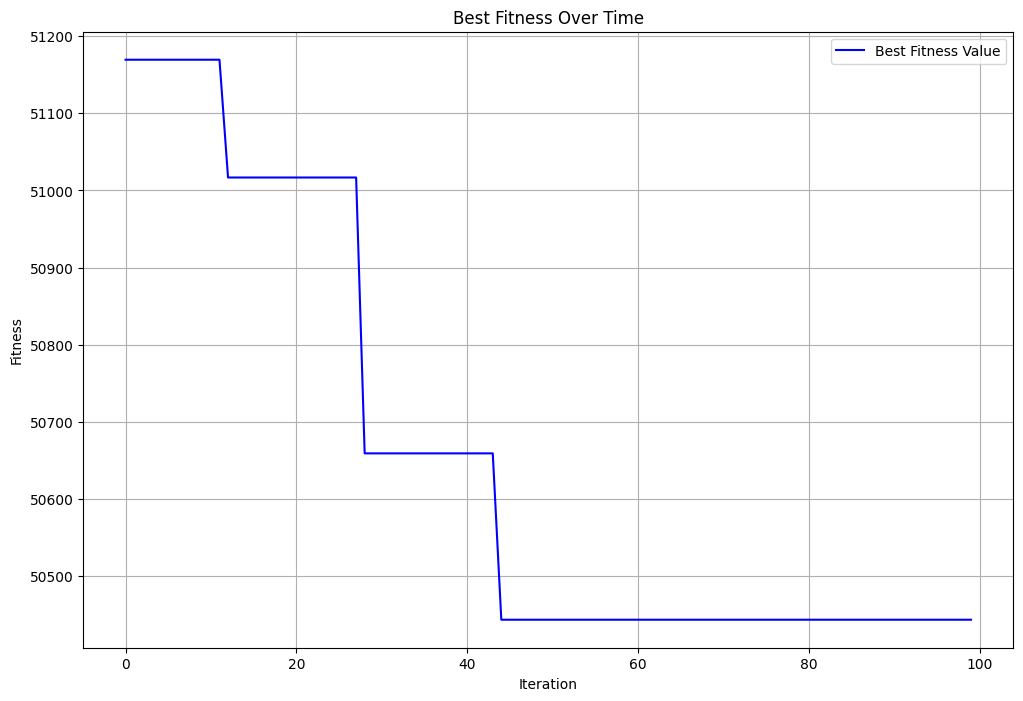

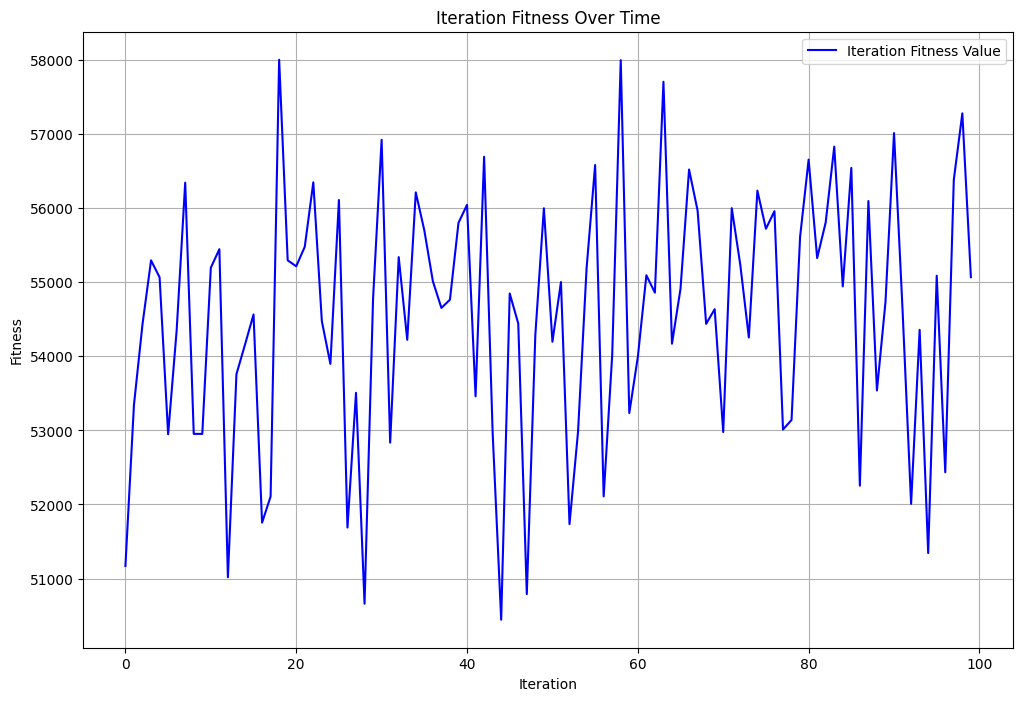

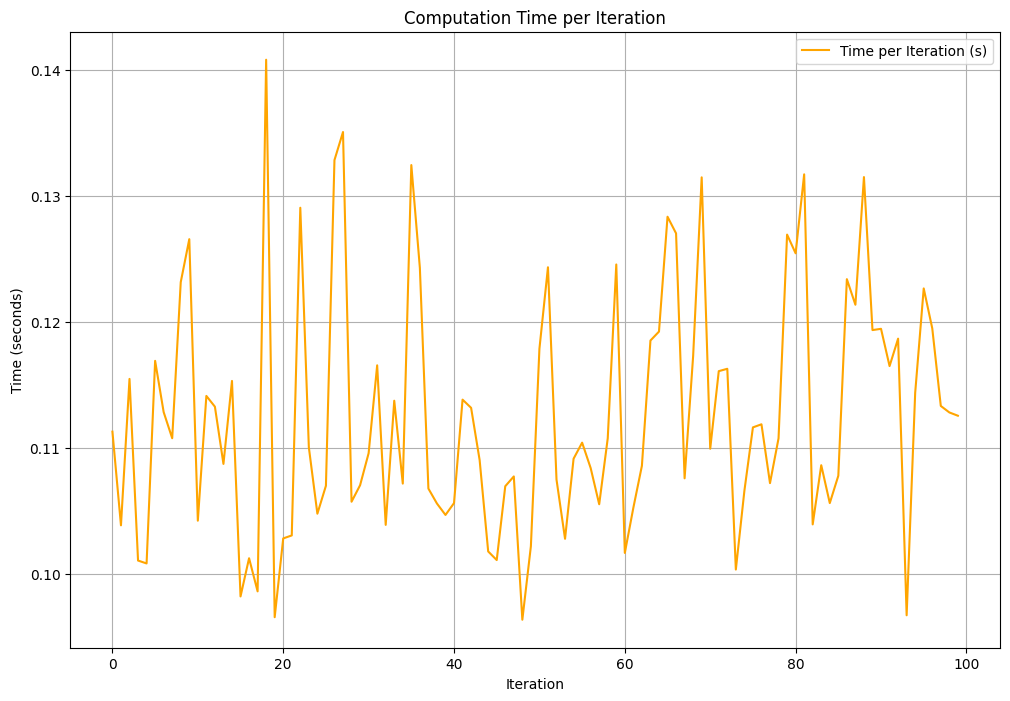

In [152]:
aco = VRPTW(distance_matrix, time_windows, 
    max_num_vehicles=25, 
    num_ants=25, 
    num_iterations=100, 
    evaporation_rate=0.95, 
    penalty_factor=100, 
    reward_factor=1,
    pheromone_multiplier=1,
    vicinity_factor=1,
    unused_penalty = 0, # Unused in more ways than one
    customer_demand = customer_demand
    )
aco.x_coords = x_coords  # Assign x_coords to the instance
aco.y_coords = y_coords  # Assign y_coords to the instance

aco.run()

# Visualization
## Param
You can give param highlight_vehicle=x where x would be the index of the vehicle starting from 0 i.e. param value of 0 will highlight the route vehicle 1 took during the best solution

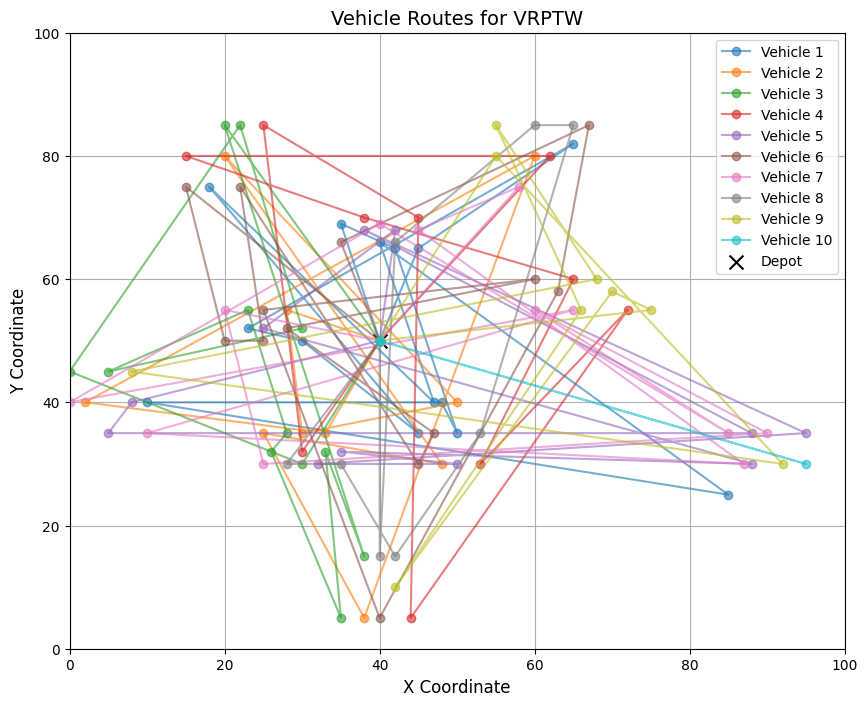

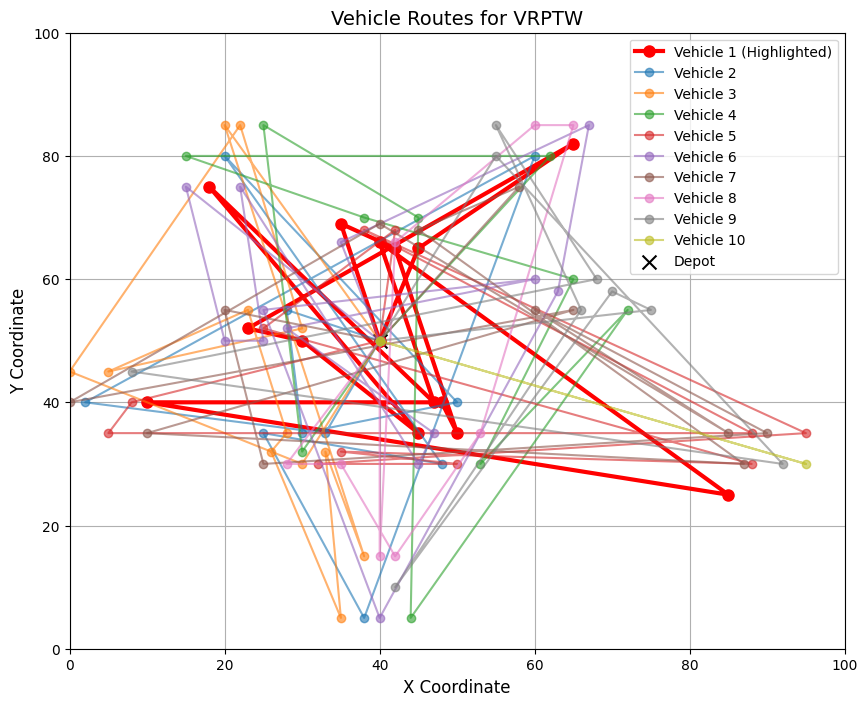

In [153]:
aco.visualize_routes()
aco.visualize_routes(highlight_vehicle=0) 